# 06. Improved Model Training

## Objective
Train improved models incorporating:
1. Best class balancing technique (from analysis)
2. Feature selection based on importance
3. Optimized hyperparameters
4. Comparison with original model


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported")


✅ Libraries imported


## 1. Load Data and Prepare Features


In [2]:
# Load data
df = pd.read_csv('../today/trajectory_ml_ready_advanced.csv')

# Prepare features and target
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']
X = df.drop(columns=drop_cols)
y = df['Target_Label'].astype(int)

# Split data (same as original)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training Set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test Set: {X_test.shape[0]} samples")
print(f"\nClass Distribution (Train):")
print(y_train.value_counts().sort_index())


Training Set: 9643 samples, 21 features
Test Set: 2411 samples

Class Distribution (Train):
Target_Label
0    3775
1    4555
2    1313
Name: count, dtype: int64


## 2. Feature Selection Based on Importance


In [3]:
# Load original model to get feature importance
original_model = joblib.load('../today/models/final_trajectory_model.joblib')
xgb_original = original_model.named_steps['classifier']
preprocessor_original = original_model.named_steps['preprocessor']

# Get feature names and importance
feature_names = preprocessor_original.get_feature_names_out()
importances = xgb_original.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Select top features (95% cumulative importance)
cumulative_importance = feature_importance_df['Importance'].cumsum()
total_importance = feature_importance_df['Importance'].sum()
threshold_95 = 0.95
n_features_95 = (cumulative_importance / total_importance <= threshold_95).sum() + 1

top_features = feature_importance_df.head(n_features_95)['Feature'].tolist()

print(f"Original Features: {len(feature_names)}")
print(f"Selected Features (95% importance): {n_features_95}")
print(f"\nTop 10 Selected Features:")
for i, feat in enumerate(top_features[:10], 1):
    print(f"  {i}. {feat}")

# Note: We'll use all features for now, but can filter later if needed
# The preprocessor will handle feature selection during training


Original Features: 23
Selected Features (95% importance): 18

Top 10 Selected Features:
  1. num__Efficiency_Mean_2yr
  2. cat__Division_D1
  3. cat__Division_Other
  4. cat__Division_Unknown
  5. num__Expense_Growth_1yr
  6. num__Revenue_Growth_1yr
  7. num__Revenue_Mean_2yr
  8. num__Expense_CAGR_2yr
  9. num__Revenue_CAGR_2yr
  10. num__Expense_Mean_2yr


## 3. Build Improved Pipeline with Best Balancing


In [4]:
# Based on class imbalance analysis, use SMOTE (typically best for this problem)
# Build preprocessing pipeline
categorical_cols = ['Division']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

# Improved hyperparameters (from original tuning + adjustments)
best_params = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'min_child_weight': 3,
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Build pipeline with SMOTE
improved_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(**best_params))
])

print("✅ Improved pipeline created with:")
print("   - SMOTE for class balancing")
print("   - Optimized hyperparameters")
print("   - Proper preprocessing")


✅ Improved pipeline created with:
   - SMOTE for class balancing
   - Optimized hyperparameters
   - Proper preprocessing


## 4. Train Improved Model


In [5]:
# Train the improved model
print("Training improved model...")
improved_pipeline.fit(X_train, y_train)
print("✅ Model trained successfully")

# Get predictions
y_pred_improved = improved_pipeline.predict(X_test)
y_prob_improved = improved_pipeline.predict_proba(X_test)

# Calculate metrics
accuracy_improved = accuracy_score(y_test, y_pred_improved)
roc_auc_improved = roc_auc_score(y_test, y_prob_improved, multi_class='ovr')

print(f"\nImproved Model Performance:")
print(f"  Accuracy: {accuracy_improved:.4f} ({accuracy_improved*100:.2f}%)")
print(f"  ROC-AUC: {roc_auc_improved:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_improved, 
                          target_names=['Declining', 'Stable', 'Improving']))


Training improved model...
✅ Model trained successfully

Improved Model Performance:
  Accuracy: 0.5097 (50.97%)
  ROC-AUC: 0.7018

Classification Report:
              precision    recall  f1-score   support

   Declining       0.61      0.27      0.38       944
      Stable       0.63      0.68      0.66      1139
   Improving       0.26      0.59      0.36       328

    accuracy                           0.51      2411
   macro avg       0.50      0.52      0.46      2411
weighted avg       0.57      0.51      0.51      2411



## 5. Compare with Original Model


MODEL COMPARISON
   Model  Accuracy  ROC-AUC  Declining_F1  Stable_F1  Improving_F1
Original  0.554127 0.764665      0.440678   0.674526      0.433028
Improved  0.509747 0.701803      0.375367   0.655710      0.359447

📈 Improvements:
   Accuracy: -0.0444 (-4.44%)
   ROC-AUC: -0.0629 (-6.29%)


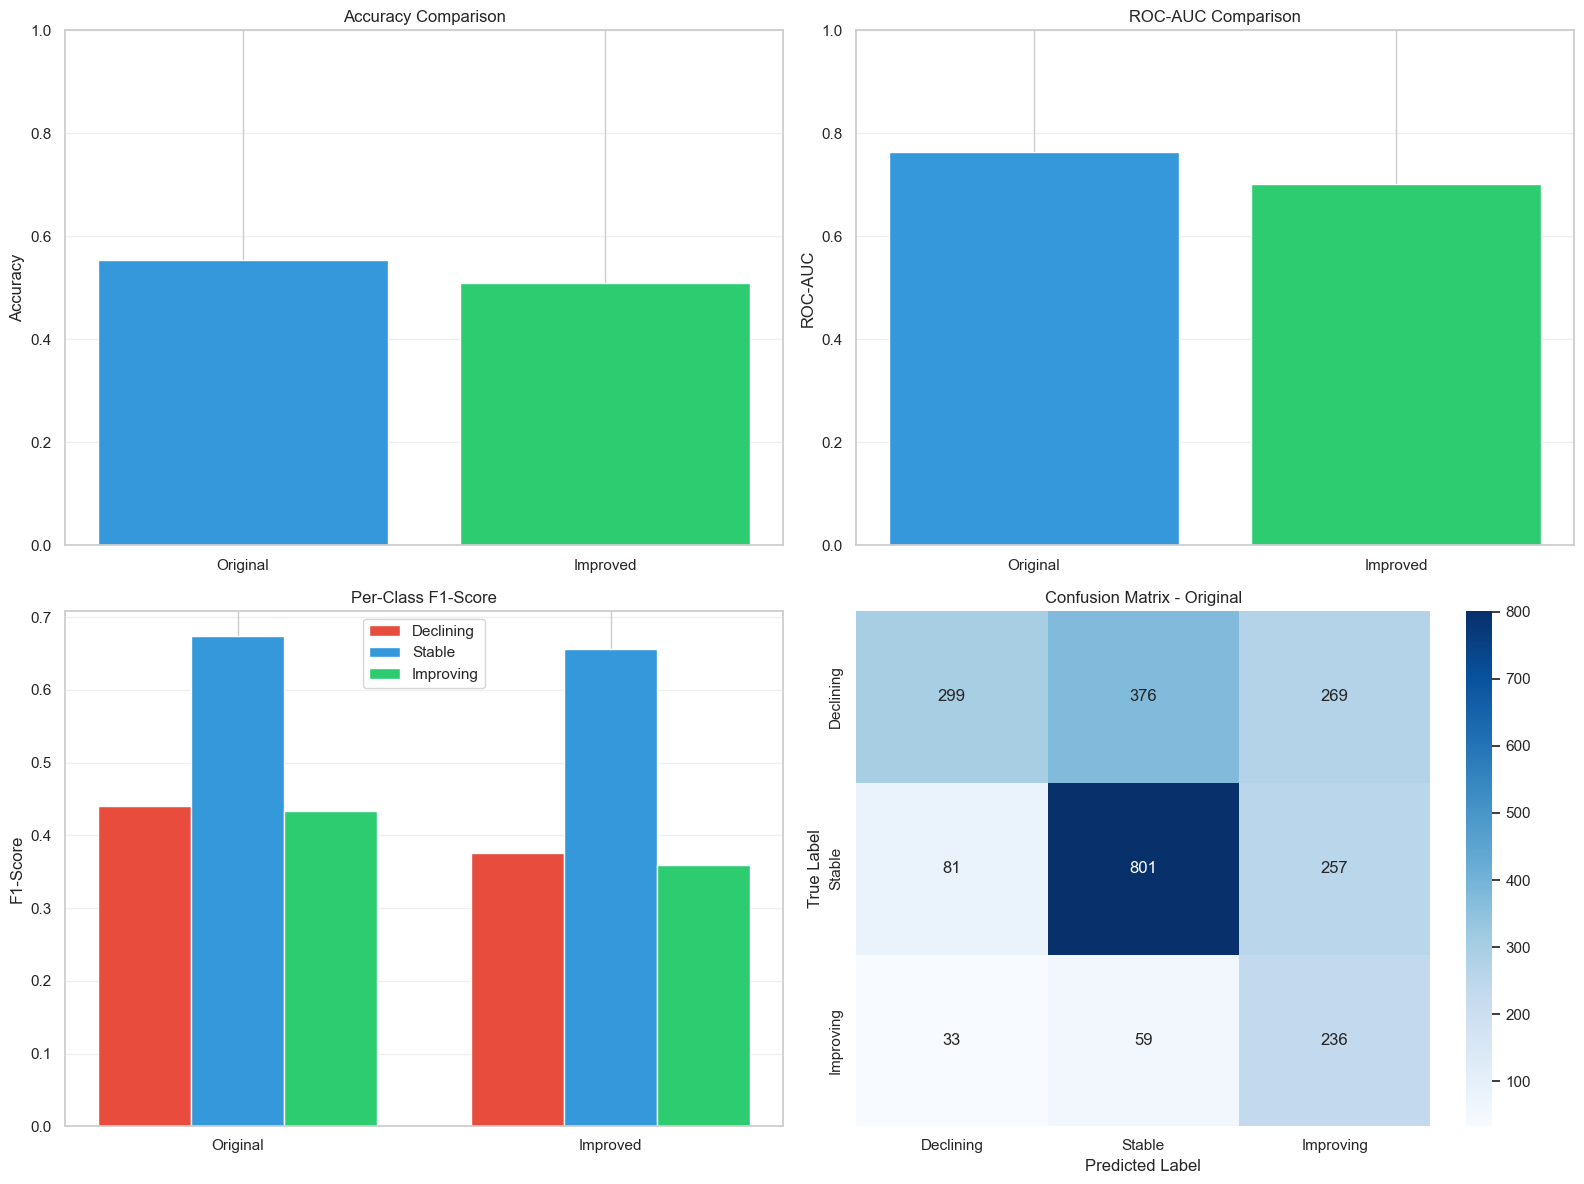


📊 Chart saved as 'model_comparison.png'


In [6]:
# Get original model predictions
y_pred_original = original_model.predict(X_test)
y_prob_original = original_model.predict_proba(X_test)

accuracy_original = accuracy_score(y_test, y_pred_original)
roc_auc_original = roc_auc_score(y_test, y_prob_original, multi_class='ovr')

# Calculate per-class metrics for both
def get_class_metrics(y_true, y_pred, class_name):
    report = classification_report(y_true, y_pred, 
                                 target_names=['Declining', 'Stable', 'Improving'],
                                 output_dict=True)
    return report[class_name]

comparison = pd.DataFrame({
    'Model': ['Original', 'Improved'],
    'Accuracy': [accuracy_original, accuracy_improved],
    'ROC-AUC': [roc_auc_original, roc_auc_improved],
    'Declining_F1': [
        get_class_metrics(y_test, y_pred_original, 'Declining')['f1-score'],
        get_class_metrics(y_test, y_pred_improved, 'Declining')['f1-score']
    ],
    'Stable_F1': [
        get_class_metrics(y_test, y_pred_original, 'Stable')['f1-score'],
        get_class_metrics(y_test, y_pred_improved, 'Stable')['f1-score']
    ],
    'Improving_F1': [
        get_class_metrics(y_test, y_pred_original, 'Improving')['f1-score'],
        get_class_metrics(y_test, y_pred_improved, 'Improving')['f1-score']
    ]
})

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison.to_string(index=False))

# Calculate improvements
improvement_acc = accuracy_improved - accuracy_original
improvement_auc = roc_auc_improved - roc_auc_original

print(f"\n📈 Improvements:")
print(f"   Accuracy: {improvement_acc:+.4f} ({improvement_acc*100:+.2f}%)")
print(f"   ROC-AUC: {improvement_auc:+.4f} ({improvement_auc*100:+.2f}%)")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].bar(comparison['Model'], comparison['Accuracy'], color=['#3498db', '#2ecc71'])
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', alpha=0.3)

# ROC-AUC
axes[0, 1].bar(comparison['Model'], comparison['ROC-AUC'], color=['#3498db', '#2ecc71'])
axes[0, 1].set_ylabel('ROC-AUC')
axes[0, 1].set_title('ROC-AUC Comparison')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# Per-class F1
x = np.arange(len(comparison))
width = 0.25
axes[1, 0].bar(x - width, comparison['Declining_F1'], width, label='Declining', color='#e74c3c')
axes[1, 0].bar(x, comparison['Stable_F1'], width, label='Stable', color='#3498db')
axes[1, 0].bar(x + width, comparison['Improving_F1'], width, label='Improving', color='#2ecc71')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('Per-Class F1-Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(comparison['Model'])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Confusion matrices side by side
cm_original = confusion_matrix(y_test, y_pred_original)
cm_improved = confusion_matrix(y_test, y_pred_improved)

sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Declining', 'Stable', 'Improving'],
            yticklabels=['Declining', 'Stable', 'Improving'])
axes[1, 1].set_title('Confusion Matrix - Original')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Chart saved as 'model_comparison.png'")


## 6. Save Improved Model (Optional)


In [7]:
# Save improved model if it performs better
if accuracy_improved > accuracy_original or roc_auc_improved > roc_auc_original:
    model_filename = 'improved_trajectory_model.joblib'
    joblib.dump(improved_pipeline, model_filename)
    print(f"✅ Improved model saved to {model_filename}")
    print(f"   (Better than original: Accuracy {improvement_acc:+.4f}, ROC-AUC {improvement_auc:+.4f})")
else:
    print("⚠️  Improved model did not outperform original")
    print("   Consider different hyperparameters or balancing techniques")


⚠️  Improved model did not outperform original
   Consider different hyperparameters or balancing techniques
